# Feature Evaluation
We will now evaluate how each model evaluates features by randomly shuffling a single column in turn and seeing how this impacts the binary accuracy score. Features of greater importance should effect this score to a larger degree. Thus feature importance is proportional to the magnitude of the change in the performance metric.

In [7]:
import pandas as pd
from joblib import load
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from scipy.stats import ks_2samp
import mplhep as hep
plt.style.use([hep.style.ROOT, hep.style.firamath])

## Get Data & Models
We get the data and the models for the rare mode below as this is a rare mode analysis notebook.

In [2]:
version = '9.0.1'
train = pd.read_csv(f'../data_files/{version}/train.csv', index_col=[0])
X_train = train.drop(['category', 'Lb_M', 'IsSimulated', 'QSQR'], axis=1)
y_train = train.category

test = df = pd.read_csv(f'../data_files/{version}/test.csv', index_col=[0])
X_test = test.drop(['category', 'Lb_M', 'IsSimulated', 'QSQR'], axis=1)
y_test = test.category

# Initial Accuracies

In [13]:
nn = tf.keras.models.load_model(f'../neural_network/models/v9.0.5')
xgb = load(f'../classification_methods/models/XGB_9.0.5.joblib')
knn = load(f'../classification_methods/models/KNN_9.0.5_tune.joblib')
dtc = load(f'../classification_methods/models/DTC_9.0.5_tune.joblib')
rfc = load(f'../classification_methods/models/RFC_9.0.5_tune.joblib')

models = {'NN': nn, 'XGB': xgb, 'KNN': knn, 'DTC': dtc, 'RFC': rfc}

/home/user211/envs/scientific/lib64/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/user211/envs/scientific/lib64/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/user211/envs/scientific/lib64/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when u

In [4]:
cols_to_shuffle = X_train.columns.to_list()

## Compute Current Metrics
We want to see how the models are currently performing before any shuffling has taken place. The best way to do this to account for class imbalance.

In [5]:
def get_predictions(models, X_train, X_test):
    train_preds = {}
    test_preds = {}

    for name, model in models.items():
        try:
            train_preds[name] = model.predict_proba(X_train.to_numpy())[:,1]
            test_preds[name] = model.predict_proba(X_test.to_numpy())[:,1]
        except:
            train_preds[name] = model.predict(X_train.to_numpy()).flatten()
            test_preds[name] = model.predict(X_test.to_numpy()).flatten()
    return train_preds, test_preds

In [19]:
def get_f1_score(train_preds, test_preds, threshold):
    scores = {}
    if type(threshold) is float:
        threshold = np.array([threshold])
    for name, pred in train_preds.items():
        model_scores = []
        for thr in threshold:
            metric = tfa.metrics.F1Score(num_classes=1, threshold=thr)
            metric.update_state(np.array([[i] for i in y_train.to_numpy()]), np.array([[i] for i in pred]))
            train_f1 = metric.result()
            
            metric = tfa.metrics.F1Score(num_classes=1, threshold=thr)
            metric.update_state(np.array([[i] for i in y_test.to_numpy()]), np.array([[i] for i in test_preds[name]]))
            test_f1 = metric.result()
            model_scores.append([train_f1, test_f1])
        scores[name] = np.squeeze(np.array(model_scores))
    return scores

def get_accuracy_score(train_preds, train_labels, test_preds, test_labels, threshold):
    scores = {}
    if type(threshold) is float:
        threshold = np.array([threshold])
    for name, pred in train_preds.items():
        model_scores = []
        for thr in threshold:
            train_acc = accuracy_score(train_labels, np.where(pred > thr, 1, 0))
            test_acc = accuracy_score(test_labels, np.where(test_preds[name] > thr, 1, 0))
            model_scores.append([train_acc, test_acc])
        scores[name] = np.squeeze(np.array(model_scores))
    return scores

def get_ks_score(train_preds, test_preds, displayPlots=False, savePlots=False, showTrain=False, showTest=True):
    scores = {}
    if displayPlots:
        fig, ax = plt.subplots(1, 1)
    bins = np.linspace(0, 1, 110)
    for name, pred in train_preds.items():
        trainh, _ = np.histogram(pred, bins=bins, density=True)
        testh, _ = np.histogram(test_preds[name], bins=bins, density=True)
        if displayPlots and showTrain and showTest:
            hep.histplot([trainh, testh], bins=bins, ax=ax, label=[f'{name} Train', f'{name} Test'])
        elif displayPlots and showTest and not showTrain:
            hep.histplot(testh, bins=bins, ax=ax, label=f'{name} Test')
        elif displayPlots and showTrain and not showTest:
            hep.histplot(trainh, bins=bins, ax=ax, label=f'{name} Train')
        else:
            pass
        ks, p = ks_2samp(trainh, testh)
        scores[name] = (ks, p)
    if displayPlots:
        plt.ylabel('Normalised Candidates')
        plt.xlabel('Predicted Probability')
        plt.legend()
        plt.tight_layout()
        if savePlots:
            plt.savefig(f'../images/ModelEval/ProbDistRare_Train={showTrain}_Test={showTest}.png')
        plt.show()
    return scores
        

def get_roc_score(train_preds, test_preds):
    # Get the ROC-AUC score and plot the ROC curves, also return the best position e.g. (0.95, 0.96)
    return 0

## Generate Initial Prediction Scores

In [20]:
orig_train_preds, orig_test_preds = get_predictions(models, X_train, X_test)
orig_f1_scores = get_f1_score(orig_train_preds, orig_test_preds, 0.85)
orig_acc_scores = get_accuracy_score(orig_train_preds, y_train, orig_test_preds, y_test, threshold=0.85)

print(orig_f1_scores, '\n')
print(orig_acc_scores)

{'NN': array([0.927728 , 0.9280606], dtype=float32), 'XGB': array([0.91693735, 0.9197991 ], dtype=float32), 'KNN': array([0.916519 , 0.9095017], dtype=float32), 'DTC': array([0.8199192, 0.8269403], dtype=float32), 'RFC': array([0.893565 , 0.8958602], dtype=float32)} 

{'NN': array([0.94754044, 0.94867947]), 'XGB': array([0.93773553, 0.94087635]), 'KNN': array([0.94030349, 0.93587435]), 'DTC': array([0.85732866, 0.86504602]), 'RFC': array([0.92459563, 0.92727091])}


# Randomly Shuffle

In [21]:
model_col_scores = {}
for col in cols_to_shuffle:
    shuffled_train = X_train.copy()
    shuffled_train[col] = np.random.permutation(X_train[col])
    
    shuffled_test = X_test.copy()
    shuffled_test[col] = np.random.permutation(X_test[col])
    
    train_preds, test_preds = get_predictions(models, shuffled_train, shuffled_test)
    
    temp_f1_score = get_f1_score(train_preds, test_preds, 0.85)
    model_col_scores[col] = temp_f1_score

print(model_col_scores)

{'JPs_FD_ORIVX': {'NN': array([0.9268966 , 0.92730844], dtype=float32), 'XGB': array([0.9142552, 0.9157638], dtype=float32), 'KNN': array([0.91621566, 0.9093732 ], dtype=float32), 'DTC': array([0.8199192, 0.8269403], dtype=float32), 'RFC': array([0.8901078 , 0.89217937], dtype=float32)}, 'LStar_ORIVX_CHI2': {'NN': array([0.9015322, 0.9043957], dtype=float32), 'XGB': array([0.9024789, 0.9044586], dtype=float32), 'KNN': array([0.9042266, 0.8966412], dtype=float32), 'DTC': array([0.8199192, 0.8269403], dtype=float32), 'RFC': array([0.86537236, 0.87187123], dtype=float32)}, 'Lb_ENDVERTEX_CHI2': {'NN': array([0.91342944, 0.9129749 ], dtype=float32), 'XGB': array([0.91693735, 0.9197991 ], dtype=float32), 'KNN': array([0.904895  , 0.89874697], dtype=float32), 'DTC': array([0.811826 , 0.8158461], dtype=float32), 'RFC': array([0.8620247, 0.8609351], dtype=float32)}, 'LN_Lb_IPCHI2_OWNPV': {'NN': array([0.9211205, 0.9232719], dtype=float32), 'XGB': array([0.90752965, 0.907433  ], dtype=float32), 

In [22]:
model_col_scores['JPs_FD_ORIVX']

{'NN': array([0.9268966 , 0.92730844], dtype=float32),
 'XGB': array([0.9142552, 0.9157638], dtype=float32),
 'KNN': array([0.91621566, 0.9093732 ], dtype=float32),
 'DTC': array([0.8199192, 0.8269403], dtype=float32),
 'RFC': array([0.8901078 , 0.89217937], dtype=float32)}

## Save Results

In [27]:
test_f1 = pd.DataFrame({'Model': ['NN', 'XGB', 'RFC', 'DTC', 'KNN']})
train_f1 = pd.DataFrame({'Model': ['NN', 'XGB', 'RFC', 'DTC', 'KNN']})

test_f1['Original'] = [orig_f1_scores[key][1] for key in list(orig_f1_scores.keys())]
train_f1['Original'] = [orig_f1_scores[key][0] for key in list(orig_f1_scores.keys())]
# Add the original F1 scores to the dataframes

test_f1.set_index('Model', inplace=True)
train_f1.set_index('Model', inplace=True)

for col in cols_to_shuffle:
    this = model_col_scores[col]
    test_f1[col] = [this[model_name][1] for model_name in list(this.keys())]
    train_f1[col] = [this[model_name][0] for model_name in list(this.keys())]
    
test_f1.head()

,Original,JPs_FD_ORIVX,LStar_ORIVX_CHI2,Lb_ENDVERTEX_CHI2,LN_Lb_IPCHI2_OWNPV,Lb_PT,LN_Lb_MINIPCHI2,LN_Lb_IP01,LN_Lb_IP23,LN_Lb_IP_OWNPV,...,JPs_ORIVX_CHI2,L1_TRACK_VeloCHI2NDOF,L2_TRACK_CHI2NDOF,JPs_IP_TOPPV,LStar_IP_ORIVX,JPs_IP_ORIVX,LN_SUM_CONEISO,LN_SUM_IPCHI2,LN_COS_THETA,LN_COS_LBDIRA
Model,,,,,,,,,,,,,,,,,,,,,
NN,0.928061,0.927308,0.904396,0.912975,0.923272,0.890914,0.912111,0.919041,0.885571,0.874376,...,0.872915,0.909883,0.927520,0.927962,0.893182,0.914579,0.911392,0.921263,0.911065,0.927479
XGB,0.919799,0.915764,0.904459,0.919799,0.907433,0.912629,0.919799,0.919440,0.903748,0.911117,...,0.919799,0.904058,0.915024,0.918758,0.889980,0.909936,0.907107,0.918398,0.918486,0.910260
RFC,0.909502,0.909373,0.896641,0.898747,0.906734,0.881849,0.904654,0.903674,0.892399,0.891005,...,0.899568,0.894707,0.906157,0.905730,0.905159,0.901052,0.904301,0.904437,0.904160,0.897194
DTC,0.826940,0.826940,0.826940,0.815846,0.740578,0.826940,0.826940,0.826940,0.826940,0.826745,...,0.764624,0.823786,0.826940,0.796294,0.815793,0.784324,0.826940,0.826940,0.826940,0.674672
KNN,0.895860,0.892179,0.871871,0.860935,0.865261,0.880164,0.865846,0.894003,0.884305,0.852429,...,0.874424,0.882735,0.893159,0.883829,0.831316,0.865575,0.892400,0.891098,0.893605,0.871787


In [30]:
test_f1.to_csv('Permutation_Importance_Test_F1_Scores.csv', header=True)
train_f1.to_csv('Permutation_Importance_Train_F1_Scores.csv', header=True)

# Visualise Results

In [46]:
test_df = pd.read_csv('Permutation_Importance_Test_F1_Scores.csv', index_col='Model')
features = test_df.columns.to_list()
test_df.head()

,Original,JPs_FD_ORIVX,LStar_ORIVX_CHI2,Lb_ENDVERTEX_CHI2,LN_Lb_IPCHI2_OWNPV,Lb_PT,LN_Lb_MINIPCHI2,LN_Lb_IP01,LN_Lb_IP23,LN_Lb_IP_OWNPV,...,JPs_ORIVX_CHI2,L1_TRACK_VeloCHI2NDOF,L2_TRACK_CHI2NDOF,JPs_IP_TOPPV,LStar_IP_ORIVX,JPs_IP_ORIVX,LN_SUM_CONEISO,LN_SUM_IPCHI2,LN_COS_THETA,LN_COS_LBDIRA
Model,,,,,,,,,,,,,,,,,,,,,
NN,0.928061,0.927308,0.904396,0.912975,0.923272,0.890914,0.912111,0.919041,0.885571,0.874376,...,0.872915,0.909883,0.927520,0.927962,0.893181,0.914579,0.911392,0.921263,0.911065,0.927479
XGB,0.919799,0.915764,0.904459,0.919799,0.907433,0.912629,0.919799,0.919440,0.903748,0.911117,...,0.919799,0.904058,0.915024,0.918758,0.889980,0.909936,0.907107,0.918398,0.918486,0.910260
RFC,0.909502,0.909373,0.896641,0.898747,0.906734,0.881849,0.904654,0.903674,0.892399,0.891005,...,0.899568,0.894707,0.906157,0.905730,0.905159,0.901052,0.904301,0.904437,0.904160,0.897194
DTC,0.826940,0.826940,0.826940,0.815846,0.740578,0.826940,0.826940,0.826940,0.826940,0.826745,...,0.764625,0.823786,0.826940,0.796294,0.815793,0.784324,0.826940,0.826940,0.826940,0.674672
KNN,0.895860,0.892179,0.871871,0.860935,0.865261,0.880164,0.865846,0.894003,0.884305,0.852429,...,0.874424,0.882735,0.893159,0.883829,0.831316,0.865575,0.892400,0.891098,0.893605,0.871787


In [47]:
# Plot the difference in the observed F1 score as a bar chart for each model (row)
test_df = test_df.T # Transpose so we can access the models as columns which is more natural

diffs = []
for model_name in models.keys():
    diffs.append(np.array([test_df['NN'].loc['Original'] - test_df['NN'].loc[feature] for feature in features if feature != 'Original']))

In [49]:
diffs[0]

array([7.521600e-04, 2.366490e-02, 1.508570e-02, 4.788700e-03,
       3.714634e-02, 1.594930e-02, 9.019700e-03, 4.248984e-02,
       5.368440e-02, 7.903170e-03, 0.000000e+00, 1.055504e-02,
       7.226120e-02, 5.514545e-02, 1.817730e-02, 5.406000e-04,
       9.865000e-05, 3.487910e-02, 1.348204e-02, 1.666815e-02,
       6.797440e-03, 1.699590e-02, 5.813000e-04])

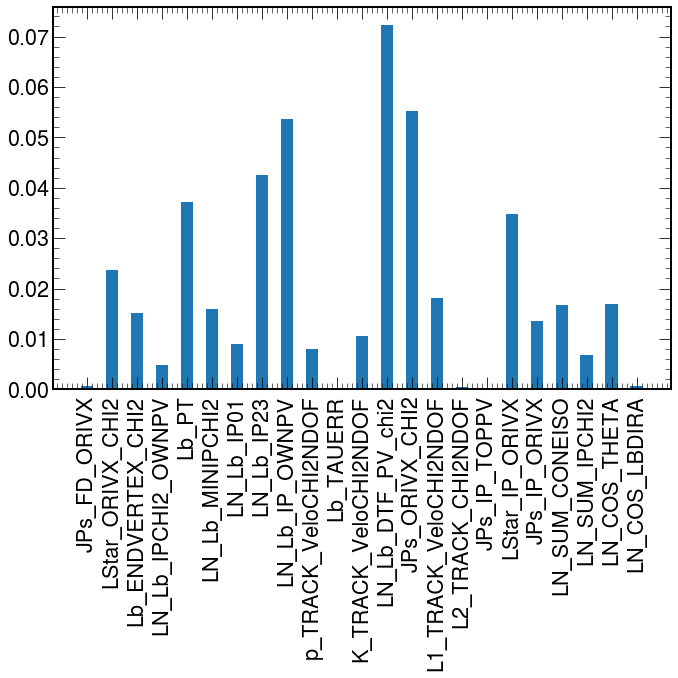

In [56]:
fig, ax = plt.subplots(1, 1)
ax.bar([f for f in features if f != 'Original'], diffs[0], width=0.5)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()